# ライブラリの読み込み

In [1]:
# 認知行動課題作成用
import itertools

# 乱数生成用
import random

# フィギュア作成用
import matplotlib.pyplot as plt

# フィギュアの日本語対応化
!pip install japanize-matplotlib
import japanize_matplotlib

# 数値や行列の計算用
import numpy as np

# [1] ニューラルネットワーク用
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# シード固定(再現性は実行順序にも依存するので注意！)
SEED = 0
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.1/4.1 MB 11.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for japanize-matplotlib: filename=japanize_matplotlib-1.1.3-py3-none-any.whl size=4120257 sha256=6c1032c757b1500add76dc88b7907dded5d3ffffc59d26c66d795fe861f9ad64
  Stored in directory: /root/.cache/pip/wheels/61/7a/6b/df1f79be9c59862525070e157e62b08eab8ece27c1b68fbb94
Successfully built japanize-matplotlib


# 活性化関数

In [2]:
#@title シグモイド関数を定義
def sigmoid(u):
    """標準シグモイド関数. 式(4-1)に相当

    Parameters
    ----------
    u : float or np.ndarray
        ニューロンモデルの内部状態

    Retruns
    -------
    y : float or np.ndarray
        ニューロンモデルの出力
    """
    y = 1 / (1+np.exp(-u))
    return y

In [3]:
#@title シグモイド関数を実行
# -10から10までの数字を1000等分
inputs = np.linspace(-10, 10, 1000)

# シグモイド関数の計算
outputs = sigmoid(u=inputs)

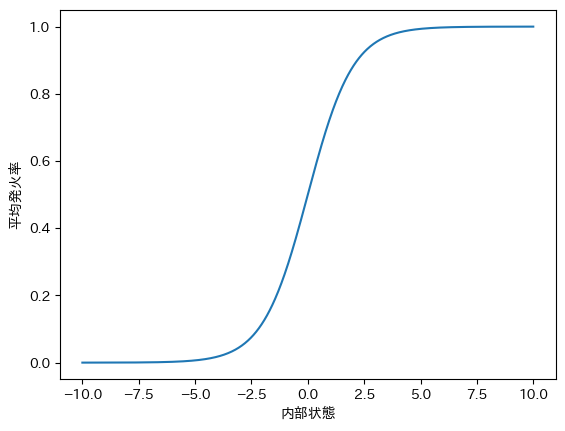

In [4]:
#@title シグモイド関数をプロット

plt.plot(inputs, outputs)  # シグモイド関数を折れ線プロット
plt.xlabel('内部状態')  # x軸のラベル名
plt.ylabel('平均発火率')  # y軸のラベル名
plt.show()  # 作成したフィギュアを表示

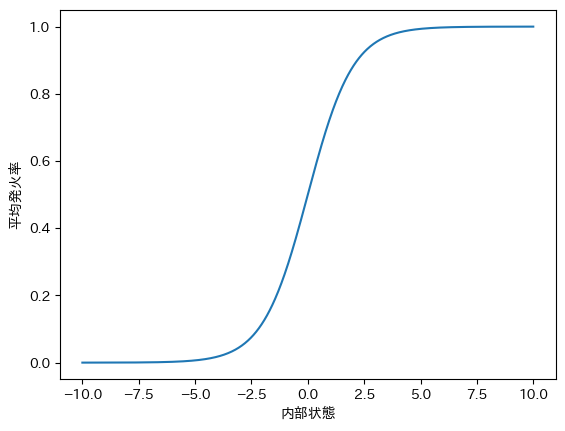

In [5]:
#@title PyTorchを用いたシグモイド関数

# -10から10までの数字を1000等分
inputs = np.linspace(-10, 10, 1000)

# Numpyの型からPyTorchの型へ変換
inputs = torch.from_numpy(inputs)

# nn.Sigmoidクラスをsigという名称でインスタンス化
sig = nn.Sigmoid()
outputs = sig(inputs)  # 内部的にはsig.call(x)が呼び出される

# プロット
plt.plot(inputs, outputs)
plt.xlabel('内部状態')
plt.ylabel('平均発火率')
plt.show()

# 線形層

In [6]:
#@title PyTorchを用いた線形層の呼び出し

# 線形層のインスタンス化
# インスタンス化の際に，重みはランダムに決定される
linear = nn.Linear(in_features=5, out_features=2)

In [7]:
#@title 線形層の動作検証

# 入力用変数の作成
inputs = torch.tensor([0.1, 0.2, 0.3, 0.4, 0.5])

# 線形層の計算. 式(4-2)に相当
outputs = linear(inputs)

# 結果を表示
print('outputs:', outputs)

outputs: tensor([-0.4157,  0.0720], grad_fn=<ViewBackward0>)


In [8]:
#@title 線形層の計算の検算
print('weight:', linear.weight)  # 線形層の重みを出力
print('bias:', linear.bias)  # 線形層のバイアスを出力
outputs = torch.mm(linear.weight, inputs.view(-1, 1)) \
    + linear.bias.view(-1, 1)
print('outputs', outputs)

weight: Parameter containing:
tensor([[-0.0033,  0.2399, -0.3681, -0.3291, -0.1722],
        [ 0.1199, -0.0089,  0.3546, -0.0397,  0.1183]], requires_grad=True)
bias: Parameter containing:
tensor([-0.1352, -0.0879], requires_grad=True)
outputs tensor([[-0.4157],
        [ 0.0720]], grad_fn=<AddBackward0>)


# 多層パーセプトロン

In [9]:
#@title 多層パーセプトロンの構築

class Perceptron(nn.Module):  # [1] クラスの定義
    """多層パーセプトロン

    線形層と活性化関数を3回繰り返すアーキテクチャ
    """
    def __init__(self, dim_input, dim_output):  # [2] 初期化関数の定義
        """パーセプトロンの初期化関数

        Parameters
        ----------
        dim_input : int
            パーセプトロンの入力次元
        dim_output : int
            パーセプトロンの出力次元
        """
        # [3] 継承元クラスの初期化関数を実行
        super().__init__()

        # 1つめの線形層と活性化関数のインスタンス化
        self.linear1 = nn.Linear(dim_input, 7)
        self.act1 = nn.Sigmoid()
        # 2つめの線形層と活性化関数のインスタンス化
        self.linear2 = nn.Linear(7, 4)
        self.act2 = nn.Sigmoid()
        # 3つめの線形層と活性化関数のインスタンス化
        self.linear3 = nn.Linear(4, dim_output)
        self.act3 = nn.Sigmoid()

    def forward(self, x):
        """パーセプトロンの前向き関数

        Parameters
        ----------
        x : torch.Tensor
            入力。サイズはデータ数 x dim_input

        Returns
        -------
        x : torch.Tensor
            出力。サイズはデータ数 x dim_output
        """
        # 1回目の線形層と活性化関数の計算. 式(4-3)に相当
        x = self.act1(self.linear1(x))
        # 2回目の線形層と活性化関数の計算. 式(4-3)に相当
        x = self.act2(self.linear2(x))
        # 3回目の線形層と活性化関数の計算. 式(4-3)に相当
        x = self.act3(self.linear3(x))
        return x

In [10]:
#@title パーセプトロンの動作検証

# 多層パーセプトロンをインスタンス化
perceptron_test = Perceptron(dim_input=16, dim_output=2)

# パーセプトロンの入力用に適当な値を持つ要素16の配列を作成
inputs = torch.Tensor([
    0.1, 0.2, 0.3, 0.4,
    0.5, 0.6, 0.7, 0.8,
    0.9, 1.0, 1.1, 1.2,
    1.3, 1.4, 1.5, 1.6
])

# 前向き計算を実行
outputs = perceptron_test(inputs)

# 出力された値を確認. 要素数が2であることが確認できる
print('Output:', outputs)

Output: tensor([0.3668, 0.6068], grad_fn=<SigmoidBackward0>)


In [11]:
#@title ストループ課題データセットの準備

def load_stroop_dataset():
    """ストループ課題のデータを作成し返す関数

    Returns
    -------
    inputs : np.ndarray
        ストループ課題の入力刺激。
        サイズはデータ数(8) x 入力次元(3)
    targets : np.ndarray
        ストループ課題の正答
        サイズはデータ数(8) x 出力次元(1)
    """
    # 入力刺激
    inputs = np.array([
        # インクの色(0:赤，1:緑)，文字の意味(0:赤，1:緑)
        # 条件(0:インク，1:意味)の順に指定
        [0, 0, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 1],
        [1, 0, 0],
        [1, 0, 1],
        [1, 1, 0],
        [1, 1, 1],
    ])
    # 正答データ
    targets = np.array([
        # 0:赤，1:緑
        [0],
        [0],
        [0],
        [1],
        [1],
        [0],
        [1],
        [1],
    ])
    return inputs, targets

# 作成したストループ課題をロードする
inputs, targets = load_stroop_dataset()

# ロードした結果を確認
print(
    'dimension of inputs:', inputs.shape,
    'dimension of targets:', targets.shape,
)

dimension of inputs: (8, 3) dimension of targets: (8, 1)


In [12]:
#@title ストループ課題プロット関数

def plot_stroop(inputs, targets, predictions=None):
    """ストループ課題のデータや結果を可視化

    Parameters
    ----------
    inputs: np.ndarray
        ストループ課題の入力刺激
    targets: np.ndarray
        ストループ課題の正答
    predictions : np.ndarray or None
        ストループ課題に対するニューラルネットの予測結果
        Noneの場合にはプロットしない
    """
    rows = ['ink', 'char', 'cond', 'true']
    if not predictions is None:
        rows = rows + ['pred']
    num_trial = len(inputs)
    heights = {
        'ink': 0,
        'char': 1,
        'cond': 2,
        'true': 3,
        'pred': 4
    }
    hatches = {
        'red': '||',
        'green' : '--',
        'white': '///',
        'tab:gray': '\\\\\\',
        # {'/', '\', '|', '-', '+', 'x', 'o', 'O', '.', '*'}
    }
    binaries = {
        'red': 0,
        'green' : 1,
        'white': 0,
        'tab:gray': 1,
    }

    plt.figure(figsize=(6, 3))
    for idx_trial in range(num_trial):
        for row in rows:
            if row in ['ink', 'char']:
                color = 'red' if inputs[idx_trial, heights[row]] == 0 else 'green'
            elif row in ['true']:
                color = 'red' if targets[idx_trial, 0] == 0 else 'green'
            elif row in ['cond']:
                color = 'white' if inputs[idx_trial, heights[row]] == 0 else 'tab:gray'
            elif row in ['pred']:
                # 便宜的に出力が0.5を下回れば赤，0.5以上だと緑と判定
                pred = 0 if predictions[idx_trial, 0] < 0.5 else 1
                color = 'red' if pred == 0 else 'green'
            else:
                raise NotImplementedError()

            # 塗りつぶしプロット
            plt.fill_between(
                np.linspace(idx_trial, idx_trial+1, 1000),
                -heights[row],
                -heights[row] - 1,
                # where=inputs[:, 0]==binaries[color],
                # interpolate=True,
                # step='mid',
                linewidth=1.5,
                facecolor=color,
                edgecolor='black',
                alpha=0.7,
                hatch=hatches[color],
            )

    # プロットの微調整
    plt.xlim(0, num_trial)
    plt.ylim(-5, 0)
    plt.xlabel('試行')
    plt.xticks(
        [idx_trial + 0.5 for idx_trial in range(num_trial)],
        range(1, num_trial + 1))
    plt.yticks(
        [-0.5, -1.5, -2.5, -3.5, -4.5],
        ['インクの色', '文字の意味', '条件', '正答', '予測'])
    plt.show()
    return

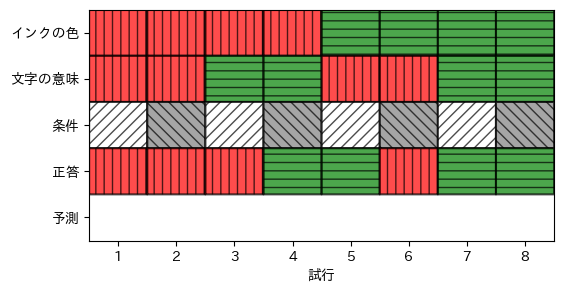

In [13]:
#@title ストループ課題データセットの可視化
plot_stroop(inputs=inputs, targets=targets)

In [14]:
#@title パーセプトロンのインスタンス化

# パーセプトロンのインスタンス化（重みはランダムに決まる）
# 今回は入力次元は3(インクの色，文字の意味，条件)
# 出力次元は1(回答の色)
perceptron_stroop = Perceptron(
    dim_input=3,
    dim_output=1,
)

predictions tensor([[0.4829],
        [0.4821],
        [0.4803],
        [0.4796],
        [0.4845],
        [0.4838],
        [0.4819],
        [0.4812]], grad_fn=<SigmoidBackward0>)


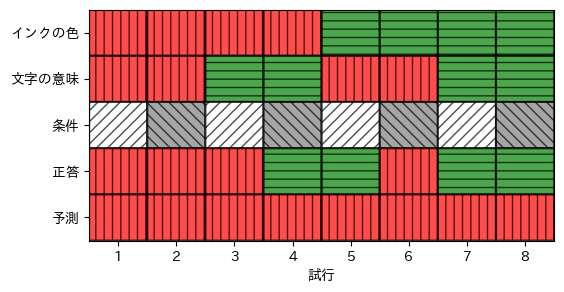

In [15]:
#@title 予測値のプロット（学習前）
# Numpy型データをPyTorch型データに変換
inputs_torch = torch.from_numpy(
    inputs).to(torch.float32)

# 予測を実行
predictions = perceptron_stroop(inputs_torch)

# 予測結果をプリント
print('predictions', predictions)

# 予測結果をプロット
plot_stroop(
    inputs=inputs,
    targets=targets,
    predictions=predictions,
)

# 誤差逆伝播法

In [16]:
#@title パーセプトロンの学習用関数の定義

def train_perceptron(net,  # [1] 学習用関数の引数を定める
                     inputs,
                     targets,
                     epoch_length,
                     lr):
    """多層パーセプトロンの学習を実行する関数

    Parameters
    ----------
    net : nn.Module
        学習対象となるパーセプトロン
    inputs : torch.Tensor
        パーセプトロンへの入力
    targets : torch.Tensor
        入力に対する正答データ
    epoch_length : int
        学習の繰り返し回数
    lr : float
        確率的勾配降下法の学習率

    Returns
    -------
    net : nn.Module
        学習済みパーセプトロン
    losses : list of float
        学習時の損失を保存したリスト
    """
    # [2] 学習のための設定
    # 最適化手法(確率的勾配降下法)をインスタンス化
    # 引数には学習の対象となるパラメータと学習率を与える
    optimizer = optim.SGD(net.parameters(), lr=lr)

    # 損失関数(最小二乗誤差)をインスタンス化
    # ゼロイチ予測の場合クロスエントロピー損失が適切だが今回は簡便にMSEを用いる
    criterion = nn.MSELoss()
    # 学習時の損失保存用リスト
    losses = []

    # [3] 学習のメインとなる繰り返し計算
    for epoch in range(1, epoch_length + 1):
        optimizer.zero_grad()  # 勾配をリセット
        outputs = net(inputs)  # 予測を実行
        loss = criterion(outputs, targets)  # 損失の計算
        loss.backward()  # 誤差逆伝播による勾配の計算
        optimizer.step()  # 勾配にもとづきパラメータを更新
        losses.append(  # 各エポックにおける損失を保存
            loss.item()  # .item()により値にのみ取得
        )
        if epoch % 1000 == 0:
            # 1000エポックごとに損失をプリントする
            print(epoch, ': ', loss.item())
    return net, losses

In [17]:
#@title 多層パーセプトロンの学習を実行
# ストループ課題データの取得
inputs, targets = load_stroop_dataset()

# Numpy型のデータをPyTorch型に変換
inputs_torch = torch.tensor(inputs, dtype=torch.float32)
targets_torch = torch.tensor(targets, dtype=torch.float32)

# パーセプトロンのインスタンス化
perceptron_stroop = Perceptron(dim_input=3, dim_output=1)

# 学習を実行
perceptron_stroop, losses = train_perceptron(
    net=perceptron_stroop,  # 多層パーセプトロン
    inputs=inputs_torch,  # 入力データ
    targets=targets_torch,  # 正答データ
    epoch_length=5000,  # 学習の繰り返し回数
    lr=0.5  # 学習率
)

1000 :  0.12529510259628296
2000 :  0.003921365365386009
3000 :  0.0010434678988531232
4000 :  0.0005560662830248475
5000 :  0.0003693803446367383


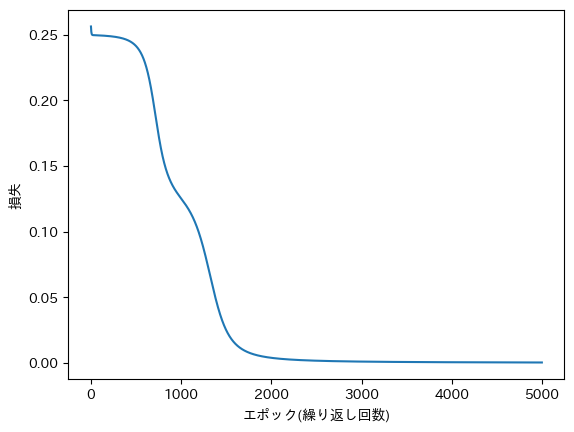

In [18]:
#@title 学習曲線をプロット
plt.plot(range(len(losses)), losses)
plt.xlabel('エポック(繰り返し回数)')
plt.ylabel('損失')
plt.show()

predictions [[0.00373013]
 [0.00352924]
 [0.02536432]
 [0.97346413]
 [0.97235495]
 [0.02821815]
 [0.9966067 ]
 [0.99715024]]


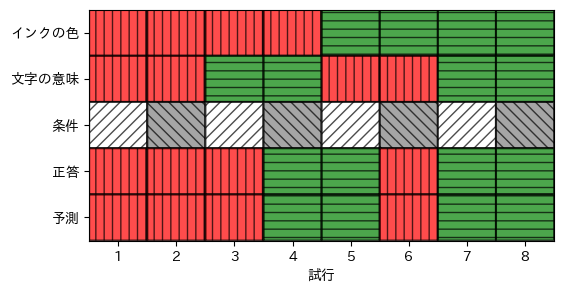

In [19]:
#@title 予測値のプロット（学習後）

# 学習後のパーセプトロンによる予測を実行
predictions = perceptron_stroop(inputs_torch)

# 予測結果から勾配情報を削除しNumpy型に変換
predictions = predictions.detach().numpy()

# 予測した値をプリントし確認する
print('predictions', predictions)

# ストループ課題の結果を可視化
plot_stroop(
    inputs=inputs,
    targets=targets,
    predictions=predictions,
)

# 追跡眼球運動課題の実装

In [20]:
#@title 1本のリサジュー曲線を作成する関数を定義

def generate_lissajous(duration,
                       amplitude_x=1,
                       amplitude_y=1,
                       freq_x=1,
                       freq_y=1,
                       delta=0):
    """1本のリサジュー曲線を作成

    Parameters
    ----------
    duration : int
        リサジュー曲線のタイムテップ数
    amplitude_x : float
        x軸の振幅
    amplitude_y : float
        y軸の振幅
    freq_x: float
        x軸の周波数
    freq_y: float
        y軸の周波数
    delta: float
        2つの正弦波の位相差

    Returns
    -------
    seq : np.ndarray
        1本のリサジュー曲線
    """
    # 評価する時間を作成
    times = np.linspace(1, duration, duration)

    # 180ステップで時刻が円周率になるように調整
    times = (times/180) * np.pi

    # リサジュー曲線を作成. 式(4-4)に相当
    x = amplitude_x * np.sin(freq_x*times)
    y = amplitude_y * np.sin(freq_y*times+delta)

    # 時刻 x 観測次元に整形
    seq = np.vstack([x, y]).T
    return seq

In [21]:
#@title リサジュー曲線のプロット用関数
def plot_lissajous(lissajous):
    """リサジュー曲線をプロット

    Parameters
    ----------
    lissajous : np.ndarray
        1本のリサジュー曲線
    """
    fig = plt.figure(figsize=(16, 3))
    ax1 = fig.add_subplot(1, 5, (1))
    ax2 = fig.add_subplot(1, 5, (2, 5))
    ax1.plot(lissajous[:, 0], lissajous[:, 1], color='tab:gray')
    ax1.set_title('平面図')
    ax2.plot(lissajous[:, 0], color='tab:blue', linestyle='solid', label='x')
    ax2.plot(lissajous[:, 1], color='black', linestyle='solid', label='y')
    ax2.legend()
    ax2.set_title('シーケンス図')
    plt.show()

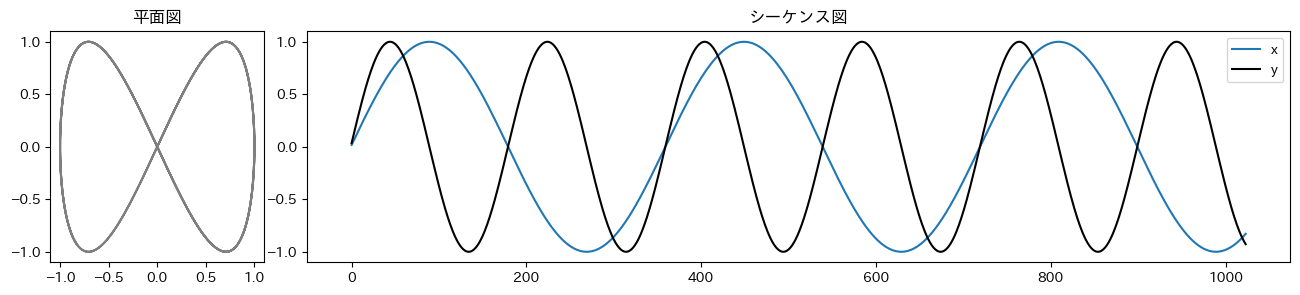

In [22]:
#@title リサジュー曲線の動作検証1
# 動作確認のためにパラメータの値を1,2と設定してプロットしてみる
seq = generate_lissajous(
    duration=1024, freq_x=1, freq_y=2)
plot_lissajous(lissajous=seq)

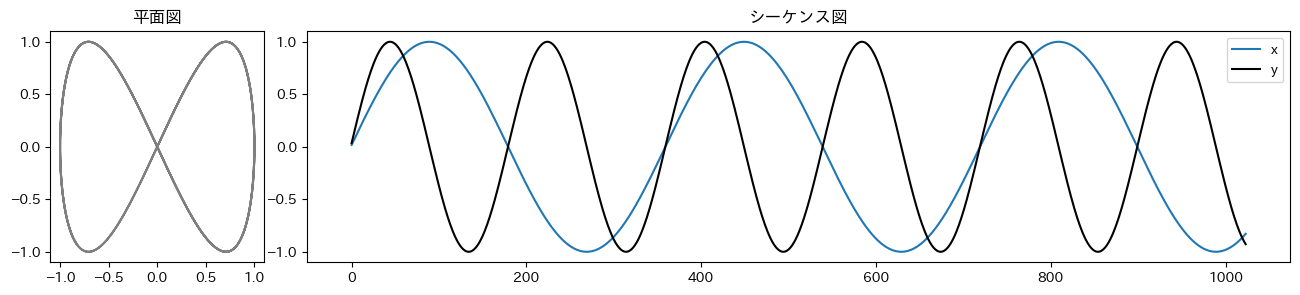

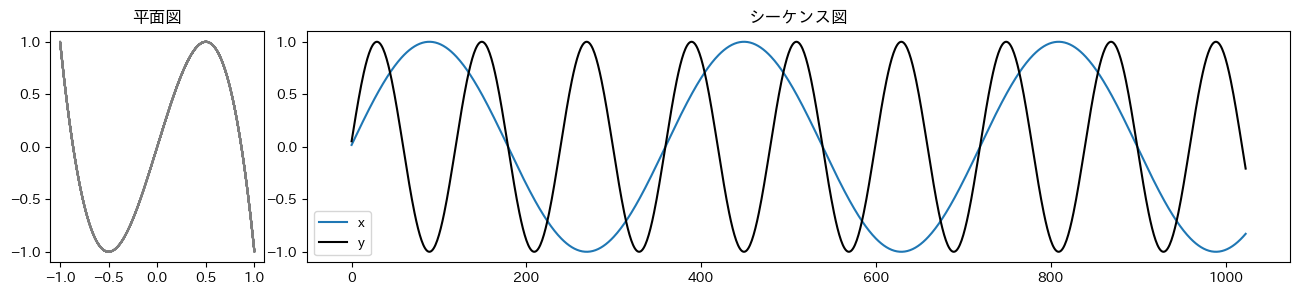

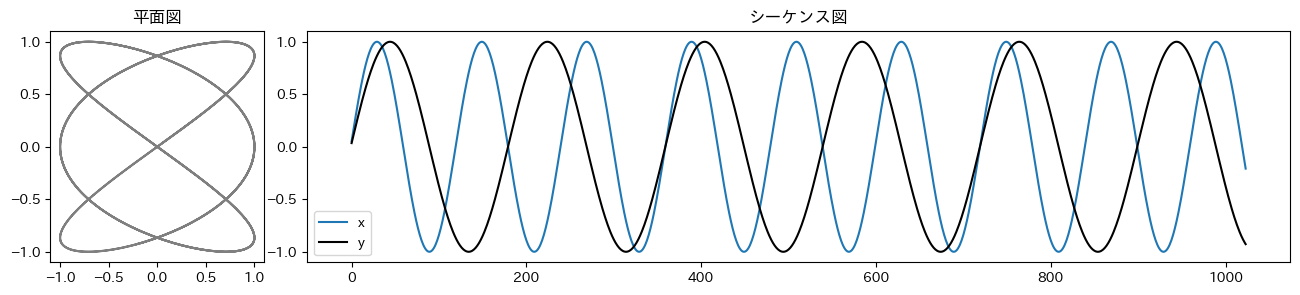

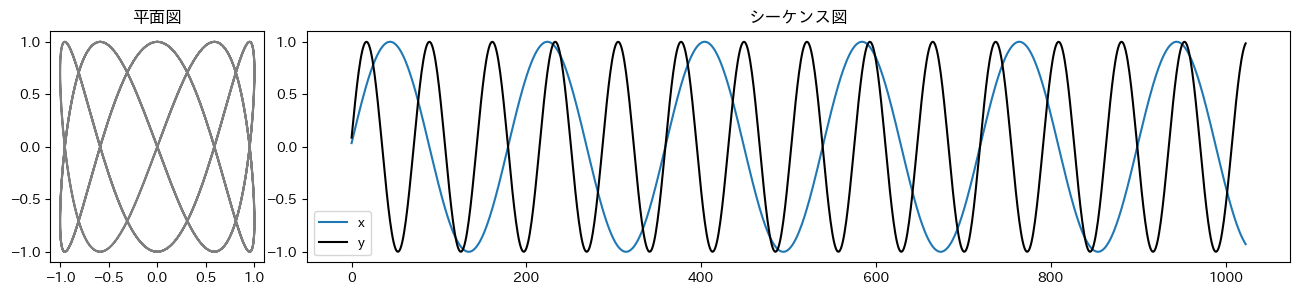

In [23]:
#@title リサジュー曲線の動作検証2
# パラメータの値を適当に設定してプロットしてみる
params = [[1, 2], [1, 3], [3, 2], [2, 5]]
for param in params:
    seq = generate_lissajous(
        duration=1024,
        freq_x=param[0],
        freq_y=param[1]
    )
    plot_lissajous(lissajous=seq)

In [24]:
#@title リサジュー曲線用データセットの構築
def load_lissajous_dataset(duration, num_seq):
    """リサジュー曲線のデータセットを作成

    Parameters
    ----------
    duration : int
        リサジュー曲線のステップ数
    num_seq : int
        リサジュー曲線の本数

    Returns
    -------
    seqs : np.ndarray
        複数本のリサジュー曲線を束ねたデータセット
        サイズはnum_seq x duration x 2
    """
    # 生成したシーケンスの保存用リスト
    seqs = []

    # 1から32までの整数から要素数が2となる直積を計算し，
    # 網羅的に設定値を含むリストを作成。
    params = list(itertools.product(
        range(1, 32), range(1, 32)))

    # x, y軸の一方に高い周波数が生じることを防ぐためにソート
    params_sum = [sum(param) for param in params]
    params = np.array(params)[
        np.argsort(params_sum)].tolist()
    # print(len(params), params)

    for i in range(num_seq):
        seq = generate_lissajous(
            duration=duration,
            # シグモイド関数の値域(0から1)よりも少し狭くする
            amplitude_x=0.3,
            amplitude_y=0.3,
            freq_x=params[i][0],
            freq_y=params[i][1],
            # 位相差は0に設定
            delta=0,
        )

        # シグモイド関数の値域に収まるように調整
        seq = seq + 0.5

        # 作成した一本のシーケンスを保存
        seqs.append(seq)
    return np.array(seqs)

sequence shape: (128, 512, 2)


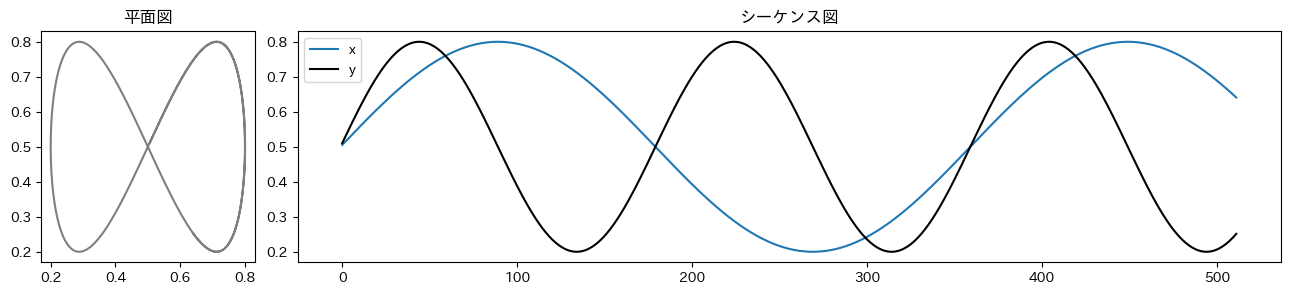

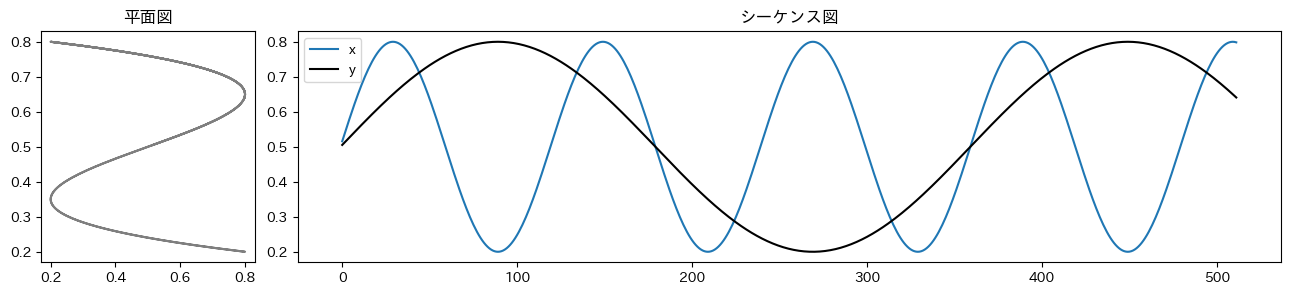

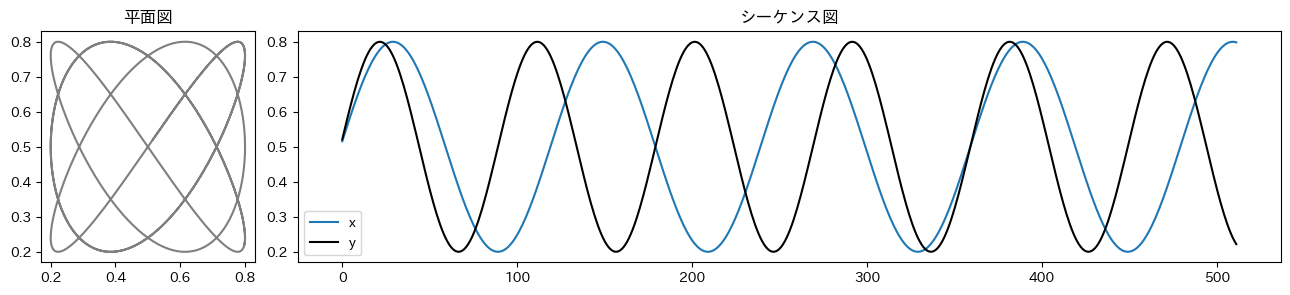

In [25]:
#@title リサジュー曲線データセットの動作検証

# データセットを作成
seqs = load_lissajous_dataset(
    duration=512, num_seq=128)

# データのサイズをチェック
print('sequence shape:', seqs.shape)

# ためしにシーケンスをプロット
for idx in [1, 4, 16]:
    plot_lissajous(lissajous=seqs[idx, :, :])

# 再起型ニューラルネットワークモデル

## CTRNNセルとCTRNNの実装

In [26]:
#@title CTRNNセルを実装
class CellCTRNN(nn.Module):
    """連続時間型RNNのセル
    """
    # [1] 初期化関数の定義
    def __init__(self, dim_inputs, dim_context, tau):
        """連続時間型RNNのセルの初期化関数

        Parameters
        ----------
        dim_input : int
            連続時間型RNNの入力次元
        dim_output : int
            連続時間型RNNの出力次元
        tau : float
            時定数
        """
        super().__init__()

        # 初期化関数に渡された設定値を保存しておく
        self.dim_inputs = dim_inputs
        self.dim_context = dim_context
        self.tau = tau

        # 線形層のインスタンス化
        self.layer_context = nn.Linear(
            dim_context, dim_inputs + dim_context)
        self.layer_inputs = nn.Linear(
            dim_inputs, dim_inputs + dim_context)

        # 活性化関数のインスタンス化
        self.activation = nn.Sigmoid()

    def forward(self, inputs, context, internal):
        """連続時間型RNNのセルの前向き計算

        Parameters
        ----------
        inputs : torch.Tensor
            連続時間型RNNの1時刻の入力
        context : torch.Tensor
            連続時間型RNNの1時刻の文脈層
        internal : torch.Tensor
            連続時間型RNNの1時刻の内部状態

        Returns
        -------
        outputs : torch.Tensor
            連続時間型RNNの1時刻の出力
        context : torch.Tensor
            連続時間型RNNの1時刻の文脈層
        internal : torch.Tensor
            連続時間型RNNの1時刻の内部状態
        """
        # [2] 内部状態の更新.
        # 式(4-5)に相当
        internal = (1-(1/self.tau))*internal \
            + (1/self.tau)*(
               self.layer_context(context) \
               + self.layer_inputs(inputs))

        # [3] 内部状態を出力用と文脈層用に分離する.
        # 式(4-7)に相当
        internal_outputs, internal_context = torch.split(
            internal,
            [self.dim_inputs, self.dim_context],
            dim=1
        )

        # [4] 活性化関数の処理.
        # 式(4-6)に相当
        context = self.activation(internal_context)
        outputs = self.activation(internal_outputs)

        # 出力に加えて次の時刻の計算で必要となる
        # context, internalも返り値にする
        return outputs, context, internal

In [27]:
#@title CTRNNセルの動作検証

# CTRNNのセルをインスタンス化
# ひとまず入力次元を2, 文脈層の次元を4, 時定数を2で設定
cell = CellCTRNN(
    dim_inputs=2,
    dim_context=4,
    tau=2,
)

# 入力と文脈層の初期値を決める
inputs = torch.tensor(
    [[-0.02, -0.03]])
context = torch.tensor(
    [[0.01, 0.02, 0.03, 0.04]])
internal = torch.tensor(
    [[0.01, 0.02, 0.03, 0.04, 0.05, 0.06]])

# 数回分の計算を繰り返す
for step in range(1, 11):
    # 1時点の前向き計算を実行
    inputs, context, internal = cell(inputs, context, internal)
    print('step:', step, 'inputs:', inputs, 'internal:', internal)

step: 1 inputs: tensor([[0.5883, 0.5697]], grad_fn=<SigmoidBackward0>) internal: tensor([[ 0.3568,  0.2807,  0.0722, -0.4086, -0.1011,  0.1742]],
       grad_fn=<AddBackward0>)
step: 2 inputs: tensor([[0.6240, 0.6524]], grad_fn=<SigmoidBackward0>) internal: tensor([[ 0.5065,  0.6298,  0.5142, -0.4266, -0.1452,  0.4740]],
       grad_fn=<AddBackward0>)
step: 3 inputs: tensor([[0.6411, 0.6959]], grad_fn=<SigmoidBackward0>) internal: tensor([[ 0.5802,  0.8278,  0.7768, -0.4065, -0.1603,  0.6230]],
       grad_fn=<AddBackward0>)
step: 4 inputs: tensor([[0.6493, 0.7192]], grad_fn=<SigmoidBackward0>) internal: tensor([[ 0.6161,  0.9406,  0.9293, -0.3826, -0.1630,  0.6978]],
       grad_fn=<AddBackward0>)
step: 5 inputs: tensor([[0.6532, 0.7320]], grad_fn=<SigmoidBackward0>) internal: tensor([[ 0.6331,  1.0049,  1.0166, -0.3639, -0.1612,  0.7359]],
       grad_fn=<AddBackward0>)
step: 6 inputs: tensor([[0.6549, 0.7391]], grad_fn=<SigmoidBackward0>) internal: tensor([[ 0.6408,  1.0415,  1.0661

In [28]:
#@title CTRNNを実装
class CTRNN(nn.Module):
    """連続時間型RNN
    """
    # [1] 初期化関数の定義
    def __init__(self, dim_inputs, dim_context, tau):
        """連続時間型RNNの初期化関数

        Parameters
        ----------
        dim_input : int
            連続時間型RNNの入力次元
        dim_output : int
            連続時間型RNNの出力次元
        tau : float
            時定数
        """
        super().__init__()
        # セルをインスタンス化
        self.cell = CellCTRNN(
            dim_inputs=dim_inputs,
            dim_context=dim_context,
            tau=tau
        )

    def get_initial_values(self, batch_size):
        """内部状態と文脈層の値を0で初期化

        Parameters
        ----------
        batch_size : int
            データ数(シーケンスの本数)

        Returns
        -------
        context : torch.Tensor
            初期ステップの文脈層
        internal : torch.Tensor
            初期ステップの内部状態
        """
        context = torch.zeros(
            batch_size, self.cell.dim_context)
        internal = torch.zeros(
            batch_size,
            self.cell.dim_inputs + self.cell.dim_context)
        return context, internal

    def forward(self, seq):
        """連続時間型RNNの前向き計算

        Parameters
        ----------
        seq : torch.tensor
            サイズはbatch x time x 入力
        Returns
        -------
        predictions: torch.tensor
            入力に対するRNNの予測
        """
        # 予測結果を保存する変数を準備
        predictions = torch.Tensor()

        # [2] 文脈層と内部状態を初期化
        context, internal = self.get_initial_values(
            batch_size=seq.size(0))

        # [3] 全時刻の計算
        for step in range(1, seq.size(1) + 1):
            # [4] 渡された全時刻シーケンスから現在の値を抽出
            inputs = seq[:, step - 1, :]

            # [5] セルを用いて一時点の計算を行う
            pred, context, internal = self.cell(
                inputs=inputs,
                context=context,
                internal=internal
            )

            # [6] 1時刻の結果を連結し全時刻にわたるデータを作成
            # シーケンス本数 x 1 x 入力次元に整形
            pred = torch.unsqueeze(pred, dim=1)
            # 全時刻の情報を保持するpredictionsに，
            # 一時点の計算結果であるpredを保存しておく
            predictions = torch.cat(
                [predictions, pred], dim=1)
        return predictions

## 学習と予測

In [29]:
#@title 追跡眼球運動用のプロット関数
def plot_sequences(targets, predictions):
    """2本のシーケンスをプロットする

    Parameters
    ----------
    targets : np.ndarray
        正答となるシーケンス(リサジュー曲線)
    predictions : np.ndarray
        RNNの予測結果
    """
    fig = plt.figure(figsize=(16, 3))
    ax_plane = fig.add_subplot(1, 5, (1))
    ax_seq = fig.add_subplot(1, 5, (2, 5))

    ax_plane.plot(
        targets[:, 0], targets[:, 1],
        label='入力', color='tab:gray', linestyle='solid')
    ax_plane.plot(
        predictions[:, 0], predictions[:, 1],
        label='予測', color='tab:gray', linestyle='dashed')
    ax_plane.set_title('平面図')
    ax_plane.legend()
    ax_plane.set_xlim(0, 1)
    ax_plane.set_ylim(0, 1)

    ax_seq.plot(
        range(len(targets[:, 0])), targets[:, 0],
        label='入力 x', color='tab:blue', linestyle='solid')
    ax_seq.plot(
        range(len(targets[:, 0])), targets[:, 1],
        label='入力 y', color='black', linestyle='solid')
    ax_seq.plot(
        range(len(predictions[:, 0])), predictions[:, 0],
        label='予測 x', color='tab:blue', linestyle='dashed')
    ax_seq.plot(
        range(len(predictions[:, 0])), predictions[:, 1],
        label='予測 y', color='black', linestyle='dashed')
    ax_seq.set_title('シーケンス図')
    ax_seq.legend()
    ax_seq.set_ylim(0, 1)

    plt.show()

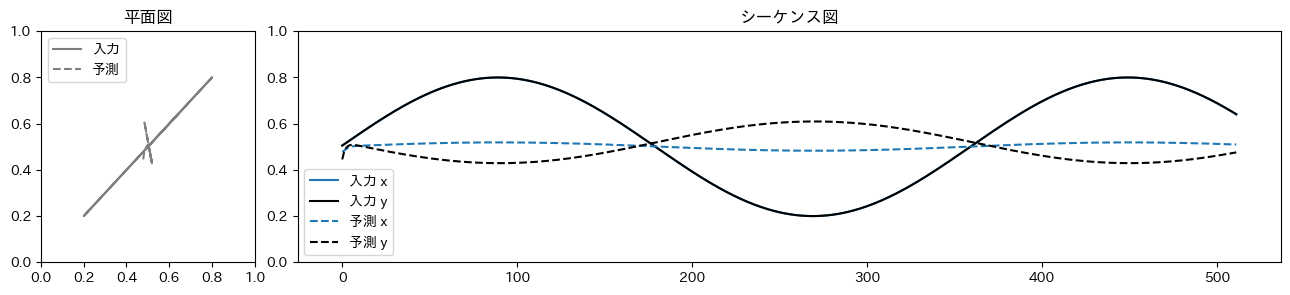

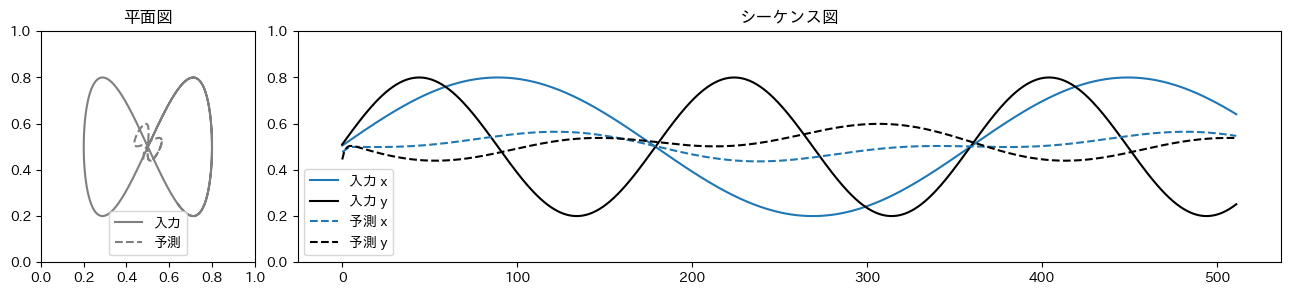

In [30]:
#@title CTRNNによる追跡眼球運動（学習前）

# リサジュー曲線を作成
targets = load_lissajous_dataset(
    duration=512, num_seq=128)

# リサジュー曲線をPyTorchのデータ型に変換
targets_torch = torch.tensor(
    targets, dtype=torch.float32)

# 設定値を与えたうえでCTRNNをインスタンス化
# 今回は文脈層のユニット数を32, 時定数を2と設定
rnn = CTRNN(dim_inputs=2, dim_context=32, tau=2)

# CTRNNで予測
predictions_torch = rnn(targets_torch)

# PyTorch型データから勾配情報を削除しNumpy型データに変換
predictions = predictions_torch.detach().numpy()

# 予測結果をプロット
for idx in range(2):
    plot_sequences(
        targets=targets[idx, :, :],
        predictions=predictions[idx, :, :]
    )

In [31]:
#@title 学習用関数の定義

def train_rnn(net, targets, epoch_length, lr):
    """RNNの学習を実行する関数

    Parameters
    ----------
    net : nn.Module
        学習対象となるRNN
    targets : torch.Tensor
        RNNの予測対象となるシーケンスデータ
    epoch_length : int
        学習の繰り返し回数
    lr : float
        確率的勾配降下法の学習率

    Returns
    -------
    net : nn.Module
        学習済みRNN
    losses : list of float
        学習時の損失を保存したリスト
    """
    # 学習のための設定
    # 最適化手法(確率的勾配降下法)をインスタンス化
    # 引数には学習の対象となるパラメータと学習率を与える
    optimizer = optim.SGD(net.parameters(), lr=lr)

    # 損失関数(最小二乗誤差)をインスタンス化
    criterion = nn.MSELoss()
    losses = []  # 学習時の損失保存用リスト

    # 学習のメインとなる繰り返し計算
    for epoch in range(1, epoch_length + 1):
        optimizer.zero_grad()  # 勾配をリセット
        predictions = net(targets)  # 予測を実行

        # [1] 損失の計算. ここだけパーセプトロンと異なる
        loss = criterion(
            # 予測値の最後の時刻以外を使用
            predictions[:, :-1, :],
            # 目標値の最初の時刻以外を使用
            targets[:, 1:, :]
        )
        loss.backward()  # 誤差逆伝播による勾配の計算
        optimizer.step()  # 勾配にもとづきパラメータを更新
        losses.append(  # 各エポックにおける損失を保存
            loss.item()  # .item()により値にのみ取得
        )
        if epoch % 1000 == 0:
            # 1000エポックごとに損失をプリントする
            print(epoch, ': ', loss.item())

    return net, losses

## 連続時間型RNNの学習実行

簡易な設定値の場合

- duration: 16
- num_seq: 2
- dim_context: 32
- tau: 2
- lr: 0.1
- epoch_length: 50000

（Google Colaboratory上で10分ほど）

In [32]:
#@title CTRNNの学習実行
# リサジュー曲線を作成
targets = load_lissajous_dataset(
    duration=16, num_seq=2)

# リサジュー曲線をPyTorchのデータ型に変換
targets_torch = torch.tensor(
    targets, dtype=torch.float32, requires_grad=True)

# 設定値を与えたうえでCTRNNをインスタンス化
# 今回は文脈層のユニット数を32, 時定数を2と設定
rnn = CTRNN(dim_inputs=2, dim_context=32, tau=2)

# 学習を実行
rnn, losses = train_rnn(
    net=rnn,
    targets=targets_torch,
    epoch_length=50000,
    lr=0.1,
)

1000 :  0.0007002587663009763
2000 :  0.0006066860514692962
3000 :  0.0005451474571600556
4000 :  0.0005032398039475083
5000 :  0.0004735209804493934
6000 :  0.00045150984078645706
7000 :  0.0004344935587141663
8000 :  0.00042082034633494914
9000 :  0.00040947002707980573
10000 :  0.00039979990106076
11000 :  0.0003913953260052949
12000 :  0.0003839758282992989
13000 :  0.0003773480129893869
14000 :  0.00037136866012588143
15000 :  0.00036592979449778795
16000 :  0.0003609469276852906
17000 :  0.00035634965752251446
18000 :  0.0003520821046549827
19000 :  0.0003480961313471198
20000 :  0.0003443514578975737
21000 :  0.00034081388730555773
22000 :  0.0003374546649865806
23000 :  0.00033424963476136327
24000 :  0.0003311768814455718
25000 :  0.0003282194084022194
26000 :  0.0003253615868743509
27000 :  0.0003225913387723267
28000 :  0.00031989801209419966
29000 :  0.00031727133318781853
30000 :  0.0003147042589262128
31000 :  0.00031219018273986876
32000 :  0.0003097236913163215
33000 : 

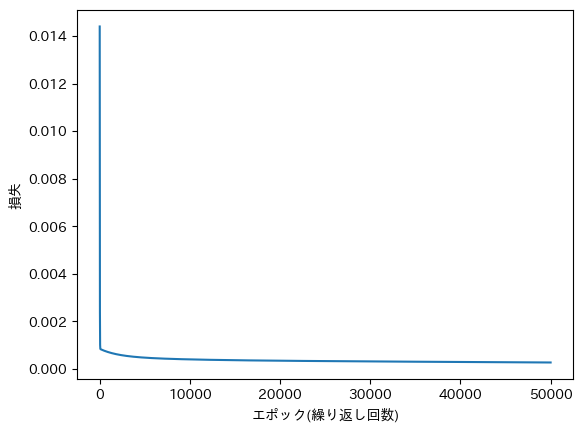

In [33]:
plt.plot(losses)
plt.xlabel('エポック(繰り返し回数)')
plt.ylabel('損失')
plt.show()

### 学習済みパラメータを読み込む場合

大規模な設定値の場合

- duration: 512
- num_seq: 128
- dim_context: 32
- tau: 2
- lr: 0.1
- epoch_length: 500000

（著者らの環境では30時間くらい必要）

In [34]:
# リサジュー曲線を作成
targets = load_lissajous_dataset(duration=512, num_seq=64)

# リサジュー曲線をPyTorchのデータ型に変換
targets_torch = torch.tensor(targets, dtype=torch.float32, requires_grad=True)

# GoogleDriveからダウンロードし名前を変更
!wget https://github.com/CPcolloquium/cp_program_book/raw/main/4_Neural-network-model/parameters/ctrnn-0.1-512-128-500000.pth
!mv ctrnn-0.1-512-128-500000.pth ctrnn.pth

# カレントディレクトリのファイル一覧にダウンロードしたものが入っているかチェック
print('ダウンロードができたか確認')
!ls

# CTRNNをインスタンス化。
# 入力次元など学習済みパラメータの個数に関わる設定値は学習時と同じにする必要がある
rnn = CTRNN(dim_inputs=2, dim_context=32, tau=2)

# ファイルからパラメータを読み込む
params = torch.load('ctrnn.pth')

# CTRNNのインスタンスに学習済みパラメータをセットする
rnn.load_state_dict(params)

--2024-07-18 00:26:21--  https://github.com/CPcolloquium/cp_program_book/raw/main/4_Neural-network-model/parameters/ctrnn-0.1-512-128-500000.pth
Resolving github.com (github.com)... 140.82.121.4
Connecting to github.com (github.com)|140.82.121.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/CPcolloquium/cp_program_book/main/4_Neural-network-model/parameters/ctrnn-0.1-512-128-500000.pth [following]
--2024-07-18 00:26:21--  https://raw.githubusercontent.com/CPcolloquium/cp_program_book/main/4_Neural-network-model/parameters/ctrnn-0.1-512-128-500000.pth
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6789 (6.6K) [application/octet-stream]
Saving to: ‘ctrnn-0.1-512-128-500000.pth’

ctrnn-0.1-512-

<All keys matched successfully>

## 予測値のプロット（学習後）

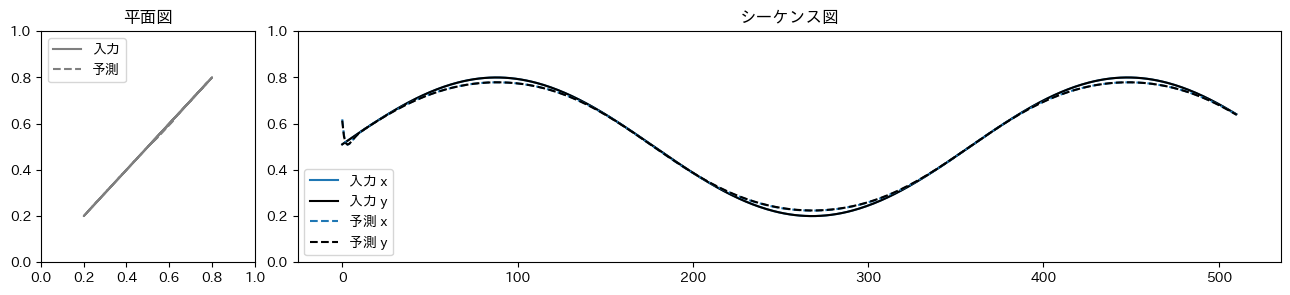

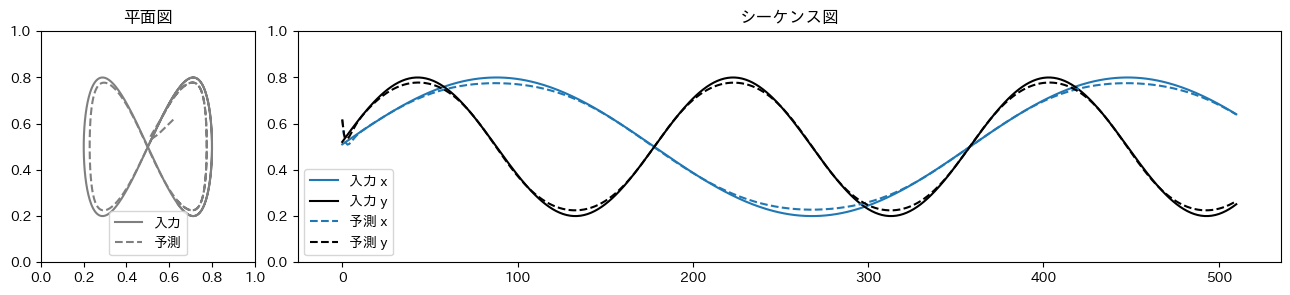

In [35]:
# 学習後のモデルで予測をしてみる
predictions = rnn(targets_torch).detach().numpy()

# 学習後の予測値をプロットしてみる
for idx in range(2):
    plot_sequences(
        # 目標値の最初の時刻以外を使用
        targets=targets[idx, 1:, :],
        # 予測値の最後の時刻以外を使用
        predictions=predictions[idx, :-1, :]
    )

# 仮想障害実験

## 仮想障害用RNNの実装

In [36]:
#@title 仮想障害用線形層
class AlteredLinear(nn.Linear):
    """仮想障害用の線形層

    一定の確率の下，線形層に結合の断絶を引き起こす

    Notes
    -----
    https://pytorch.org/docs/stable/_modules/torch/nn/modules/linear.html#Linear
    """
    def __init__(self, in_features, out_features):
        """仮想障害用の線形層の初期化関数

        Parameters
        ----------
        in_features : int
            入力次元数
        out_features : int
            出力次元数
        """
        super().__init__(
            in_features=in_features,
            out_features=out_features
        )
        self.init_disconnection_matrix(disconnection_prob=0.5)

    def init_disconnection_matrix(self, disconnection_prob):
        """結合の断絶を0か1でコーディングした配列を初期化

        Parameters
        ----------
        disconnection_prob : float
            断絶を起こす確率（0から1の値）
        """
        # 要素に結合の確率値(0から1)を有する配列を作成
        disconnection_prob_matrix = torch.full_like(
            self.weight,
            fill_value=disconnection_prob,
            dtype=torch.float
        )

        # 要素に断絶の値(0か1か)を有する配列を作成
        self.disconnection_matrix = torch.bernoulli(
            # 1を生成する確率を与えるため，減算を施す
            1 - disconnection_prob_matrix
        )
        # print(disconnection_matrix)

    def forward(self, input, disconnection=False):
        """仮想障害用の線形層の前向き計算

        disconnectionがFalseのときは通常の線形層の計算
        disconnectionがTrueのときは，結合の断絶を起こして線形層の計算を行う
        どのニューロンユニット間の結合を断絶するのかは，self.disconnection_matrixに従う

        Parameters
        ----------
        input : torch.Tensor
            入力
        disconnection : boolean
            線形層の計算で結合の断絶を引き起こすかどうか
        """
        if disconnection:
            # 断絶する場合にはself.weightそのものを
            # 使う代わりに， self.weightに断絶の配列を乗じる
            weight = self.disconnection_matrix * self.weight
        else:
            # 断絶しない場合には本来のweightを使う
            weight = self.weight

        # 線形層の計算
        x = F.linear(input, weight, self.bias)
        return x

In [37]:
#@title 仮想障害用CTRNNセル
class AlteredCellCTRNN(nn.Module):
    """仮想障害用連続時間型RNNのセル
    """

    def __init__(self, dim_inputs, dim_context, tau):
        """仮想障害用連続時間型RNNのセルの初期化関数

        Parameters
        ----------
        dim_input : int
            連続時間型RNNの入力次元
        dim_output : int
            連続時間型RNNの出力次元
        tau : float
            時定数
        """
        super().__init__()

        # 初期化関数に渡された設定値を保存しておく
        self.dim_inputs = dim_inputs
        self.dim_context = dim_context
        self.tau = tau

        # 線形層のインスタンス化
        # [1] 使用する線形層を実装したAlteredLinearに差し替える
        self.layer_context = AlteredLinear(
            dim_context, dim_inputs + dim_context)
        self.layer_inputs = nn.Linear(
            dim_inputs, dim_inputs + dim_context)

        # 活性化関数のインスタンス化
        self.activation = nn.Sigmoid()

    def forward(self, inputs, context, internal, disconnection=False):
        """連続時間型RNNのセルの前向き計算

        Parameters
        ----------
        inputs : torch.Tensor
            連続時間型RNNの1時刻の入力
        context : torch.Tensor
            連続時間型RNNの1時刻の文脈層
        internal : torch.Tensor
            連続時間型RNNの1時刻の内部状態

        Returns
        -------
        outputs : torch.Tensor
            連続時間型RNNの1時刻の出力
        context : torch.Tensor
            連続時間型RNNの1時刻の文脈層
        internal : torch.Tensor
            連続時間型RNNの1時刻の内部状態
        """

        # 内部状態の更新
        internal = (1 - (1 / self.tau)) * internal \
            + (1 / self.tau) * (
                self.layer_context(
                    context, disconnection=disconnection)  \
                + self.layer_inputs(inputs)
            )

        # 内部状態を出力用と文脈層用に分離する
        internal_outputs, internal_context = torch.split(
            internal,
            [self.dim_inputs, self.dim_context],
            dim=1
        )

        # 活性化関数の処理
        context = self.activation(internal_context)
        outputs = self.activation(internal_outputs)

        # 出力に加えて次の時刻の計算で必要となる
        # context, internalも返り値にする
        return outputs, context, internal

### 時系列全体のモデルを実装

In [38]:
class AlteredCTRNN(nn.Module):
    def __init__(self, dim_inputs, dim_context, tau):
        """仮想障害用連続時間型RNNの初期化関数

        Parameters
        ----------
        dim_input : int
            連続時間型RNNの入力次元
        dim_output : int
            連続時間型RNNの出力次元
        tau : float
            時定数
        """
        super().__init__()
        self.cell = AlteredCellCTRNN(
            dim_inputs=dim_inputs,
            dim_context=dim_context,
            tau=tau,
        )

    def get_initial_values(self, batch_size):
        """内部状態と文脈層の値を0で初期化

        Parameters
        ----------
        batch_size : int
            データ数(シーケンスの本数)

        Returns
        -------
        context : torch.Tensor
            初期ステップの文脈層
        internal : torch.Tensor
            初期ステップの内部状態
        """
        context = torch.zeros(
            batch_size, self.cell.dim_context)
        internal = torch.zeros(
            batch_size,
            self.cell.dim_inputs + self.cell.dim_context)
        return context, internal

    def forward(self, seq):
        """連続時間型RNN(仮想障害)の通常用前向き計算

        Parameters
        ----------
        seq : torch.tensor
            サイズはbatch x time x 入力

        Returns
        -------
        predictions: torch.tensor
            入力に対するRNNの予測
        """
        # 予測結果を保存する変数を準備
        predictions = torch.Tensor()

        # 文脈層と内部状態を初期化
        context, internal = self.get_initial_values(
            batch_size=seq.size(0))

        for step in range(1, seq.size(1) + 1):
            # 渡された全時刻シーケンスから現在の値を抽出
            inputs = seq[:, step - 1, :]

            # 1時点における予測
            pred, context, internal = self.cell(
                inputs=inputs,
                context=context,
                internal=internal
            )

            # 1時刻の結果を連結し全時刻にわたるデータを作成
            pred = torch.unsqueeze(pred, dim=1)
            predictions = torch.cat(
                [predictions, pred], dim=1)
        return predictions

    def forward_noise(self, seq, noise_scale=0.01):
        """入力層におけるノイズ混入での前向き計算

        Parameters
        ----------
        seq : torch.tensor
            サイズはbatch x time x 入力
        noise_scale : float
            入力層におけるノイズの標準偏差

        Returns
        -------
        predictions: torch.tensor
            入力に対するRNNの予測
        """
        # 予測結果を保存する変数を準備
        predictions = torch.Tensor()

        # 文脈層と内部状態を初期化
        context, internal = self.get_initial_values(
            batch_size=seq.size(0))

        for step in range(1, seq.size(1) + 1):
            # 渡された全時刻シーケンスから現在の値を抽出
            inputs = seq[:, step - 1, :]

            # [1] ノイズの生成と加算
            noises = torch.normal(0, noise_scale, inputs.shape)
            inputs = inputs + noises

            # セルを用いて一時点の計算を行う
            pred, context, internal = self.cell(
                inputs=inputs,
                context=context,
                internal=internal
            )

            # 1時刻の結果を連結し全時刻にわたるデータを作成
            pred = torch.unsqueeze(pred, dim=1)
            predictions = torch.cat(
                [predictions, pred], dim=1)
        return predictions

    def forward_delay(self,
                      seq,
                      delay_time=2,
                      abnormal_prob=0.1):
        """文脈層の信号遅延の場合の前向き計算

        Parameters
        ----------
        seq : torch.tensor
            サイズはbatch x time x 入力
        delay_time : int
            時間遅延のタイムステップ数
        abnormal_prob : float
            時間遅延を引き起こす確率

        Returns
        -------
        predictions: torch.tensor
            入力に対するRNNの予測
        """
        # 予測結果を保存する変数を準備
        predictions = torch.Tensor()

        # 文脈層と内部状態を初期化
        context, internal = self.get_initial_values(
            batch_size=seq.size(0))

        # [1] 遅延信号として保存するリストを準備
        # context_delayは，先頭に（インデックスが小さい位置）に
        # 古い時間のcontextを保持するリスト
        context_delay = []

        for step in range(1, seq.size(1) + 1):
            # 渡された全時刻シーケンスから現在の値を抽出
            inputs = seq[:, step - 1, :]

            # [2] 一番新しい時間のcontextを追加
            context_delay.append(context)
            # [3] 一番古い時間のcontextを削除
            if step > delay_time:
                _ = context_delay.pop(0)

            # [4] 遅延信号を使うかどうかを判定
            if random.random() <= abnormal_prob:
                # 一番古い時間のcontextに差し替える
                #print('sashikae')
                context_used = context_delay[0]
            else:
                # 通常通りのcontextを用いる
                #print('tuuzyo')
                context_used = context_delay[-1]
            #print(
            #    'context_delay: ', context_delay,
            #    context_used': ', context_used,
            #)
            # [5] セルを用いて一時点の計算を行う
            pred, context, internal = self.cell(
                inputs=inputs,
                context=context_used,
                internal=internal,
            )

            # 1時刻の結果を連結し全時刻にわたるデータを作成
            pred = torch.unsqueeze(pred, dim=1)
            predictions = torch.cat(
                [predictions, pred], dim=1)
        return predictions


    def forward_disconnection(self,
                              seq,
                              disconnection_prob=0.1):
        """文脈層の結合断絶の場合の前向き計算

        Parameters
        ----------
        seq : torch.tensor
            サイズはbatch x time x 入力
        disconnection_prob : float
            結合断絶を引き起こす際に，どれくらいの数の重み付け係数を0にするか

        Returns
        -------
        predictions: torch.tensor
            入力に対するRNNの予測
        """
        # 予測結果を保存する変数を準備
        predictions = torch.Tensor()

        # 文脈層と内部状態を初期化
        context, internal = self.get_initial_values(
            batch_size=seq.size(0))

        # 重みづけ係数における結合断絶する位置を初期化
        # RNNのセル(self.cell)が所持する文脈層の線形層
        # (layer_context)にアクセスし，関数を呼び出す
        self.cell.layer_context.init_disconnection_matrix(
            disconnection_prob=disconnection_prob
        )

        for step in range(1, seq.size(1) + 1):
            # 渡された全時刻シーケンスから現在の値を抽出
            inputs = seq[:, step - 1, :]

            # [1] セルを用いて一時点の計算を行う
            pred, context, internal = self.cell(
                inputs=inputs,
                context=context,
                internal=internal,
                # 以下をTrueに変更し全結合の計算で断絶を行う
                disconnection=True
            )

            # 1時刻の結果を連結し全時刻にわたるデータを作成
            pred = torch.unsqueeze(pred, dim=1)
            predictions = torch.cat(
                [predictions, pred], dim=1)
        return predictions

## 仮想障害シミュレーション：学習編

In [39]:
#@title 通常条件での学習実行

# リサジュー曲線を作成
targets = load_lissajous_dataset(
    duration=16,
    num_seq=2,
)

# リサジュー曲線をPyTorchのデータ型に変換
targets_torch = torch.tensor(
    targets,
    dtype=torch.float32,
    requires_grad=True,
)

# 設定値を与えたうえでAlteredCTRNNをインスタンス化
rnn_altered = AlteredCTRNN(
    dim_inputs=2,
    dim_context=32,
    tau=2,
)

# 学習を実行
rnn_altered, losses = train_rnn(
    net=rnn_altered,
    targets=targets_torch,
    epoch_length=50000,
    lr=0.1,
)

1000 :  0.0006026326445862651
2000 :  0.0005711267003789544
3000 :  0.0005466080037876964
4000 :  0.0005267162923701108
5000 :  0.0005100668058730662
6000 :  0.0004958135541528463
7000 :  0.0004834172723349184
8000 :  0.0004725137841887772
9000 :  0.00046283897245302796
10000 :  0.0004541926900856197
11000 :  0.00044641332351602614
12000 :  0.0004393701092340052
13000 :  0.00043295096838846803
14000 :  0.00042706256499513984
15000 :  0.00042162436875514686
16000 :  0.0004165676364209503
17000 :  0.00041183552821166813
18000 :  0.0004073779273312539
19000 :  0.0004031520220451057
20000 :  0.00039912352804094553
21000 :  0.000395262788515538
22000 :  0.0003915451525244862
23000 :  0.00038794975262135267
24000 :  0.0003844590100925416
25000 :  0.0003810586058534682
26000 :  0.0003777365491259843
27000 :  0.00037448329385370016
28000 :  0.0003712909237947315
29000 :  0.00036815257044509053
30000 :  0.00036506203468889
31000 :  0.00036201480543240905
32000 :  0.00035900724469684064
33000 : 

In [40]:
#@title 学習済みパラメータを読み込む場合

# リサジュー曲線を作成
targets = load_lissajous_dataset(duration=512, num_seq=64)

# リサジュー曲線をPyTorchのデータ型に変換
targets_torch = torch.tensor(targets, dtype=torch.float32, requires_grad=True)

# GoogleDriveからダウンロードし名前を変更 (通常のCTRNNと同じ)
!wget https://github.com/CPcolloquium/cp_program_book/raw/main/4_Neural-network-model/parameters/ctrnn-0.1-512-128-500000.pth
!mv ctrnn-0.1-512-128-500000.pth ctrnn.pth

# カレントディレクトリのファイル一覧にダウンロードしたものが入っているかチェック
print('ダウンロードができたか確認')
!ls

# AllteredCTRNNをインスタンス化。
# 入力次元など学習済みパラメータの個数に関わる設定値は学習時と同じにする必要がある
rnn_altered = AlteredCTRNN(dim_inputs=2, dim_context=32, tau=2)

# ファイルからパラメータを読み込む
params = torch.load('ctrnn.pth')

# CTRNNのインスタンスに学習済みパラメータをセットする
rnn_altered.load_state_dict(params)

--2024-07-18 00:34:20--  https://github.com/CPcolloquium/cp_program_book/raw/main/4_Neural-network-model/parameters/ctrnn-0.1-512-128-500000.pth
Resolving github.com (github.com)... 140.82.121.4
Connecting to github.com (github.com)|140.82.121.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/CPcolloquium/cp_program_book/main/4_Neural-network-model/parameters/ctrnn-0.1-512-128-500000.pth [following]
--2024-07-18 00:34:20--  https://raw.githubusercontent.com/CPcolloquium/cp_program_book/main/4_Neural-network-model/parameters/ctrnn-0.1-512-128-500000.pth
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6789 (6.6K) [application/octet-stream]
Saving to: ‘ctrnn-0.1-512-128-500000.pth’

ctrnn-0.1-512-

<All keys matched successfully>

## 仮想障害シミュレーション：予測編

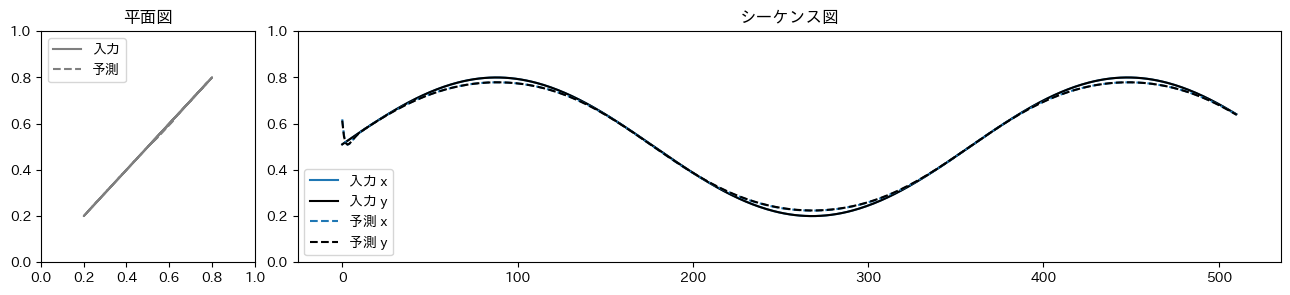

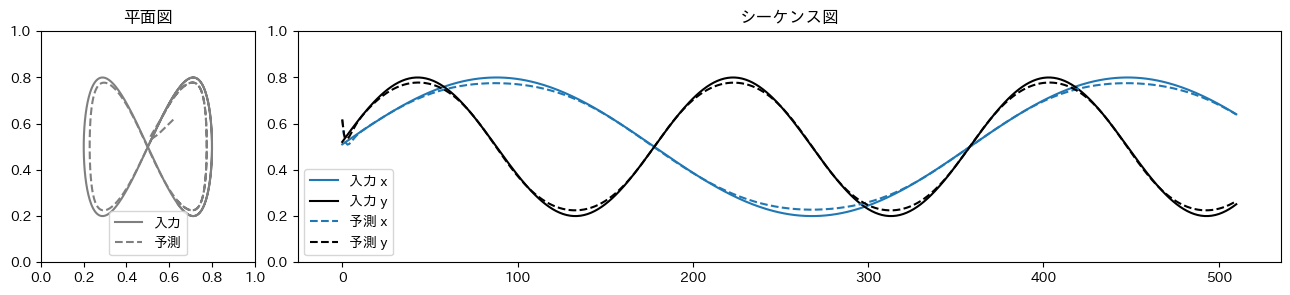

In [41]:
#@title 通常条件での予測

# 前向き計算による予測
predictions_normal = rnn_altered(
    targets_torch
).detach().numpy()

# 予測結果をプロット
for idx in range(2):
    plot_sequences(
        targets=targets[idx, 1:, :],
        predictions=predictions_normal[idx, :-1, :],
    )

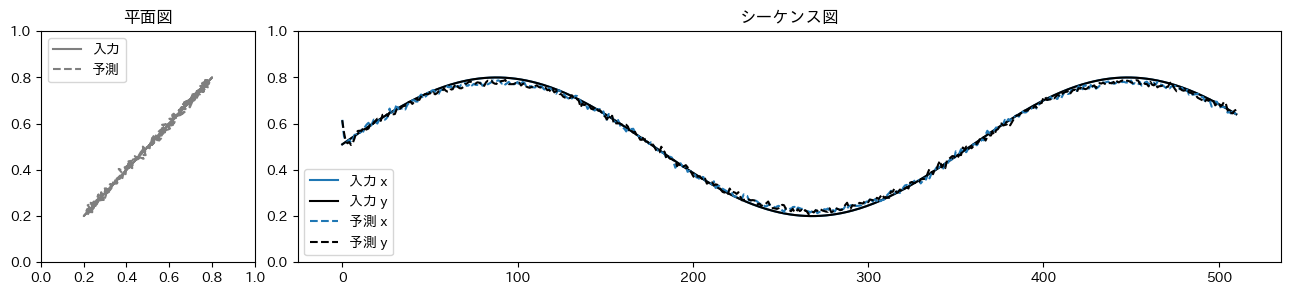

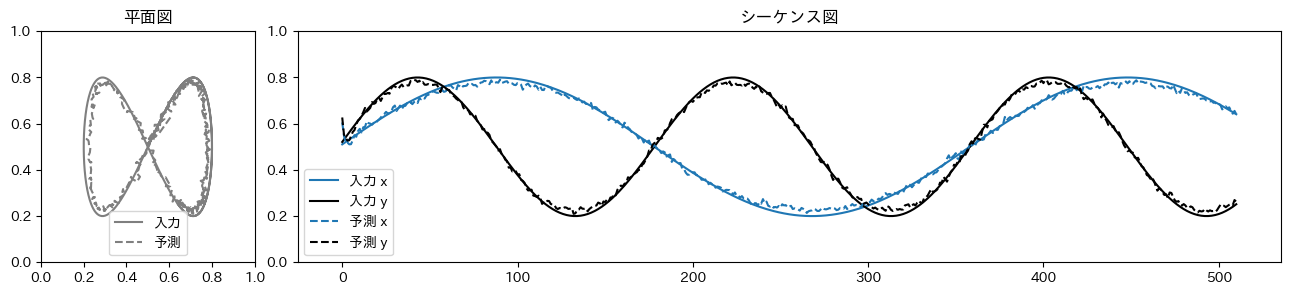

In [42]:
#@title ノイズの混入での予測

# 前向き計算による予測
predictions_noise = rnn_altered.forward_noise(
    targets_torch,
    noise_scale=0.01,  # 仮想障害実験ではここを調整！
).detach().numpy()

# 予測結果をプロット
for idx in range(2):
    plot_sequences(
        targets=targets[idx, 1:, :],
        predictions=predictions_noise[idx, :-1, :],
    )

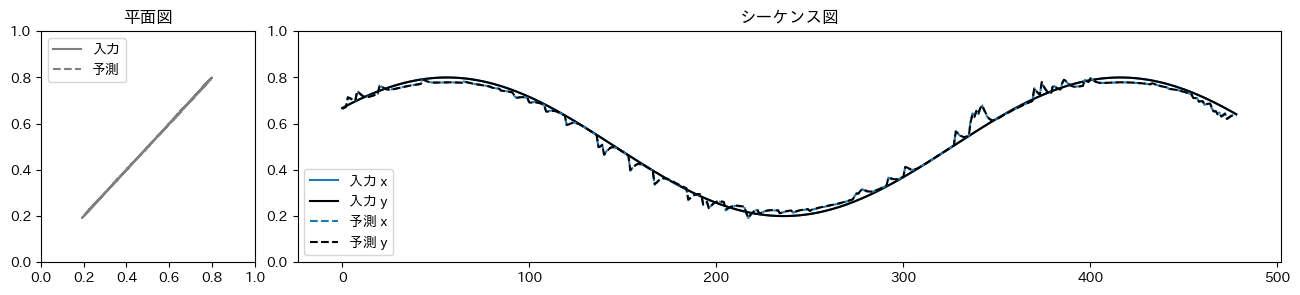

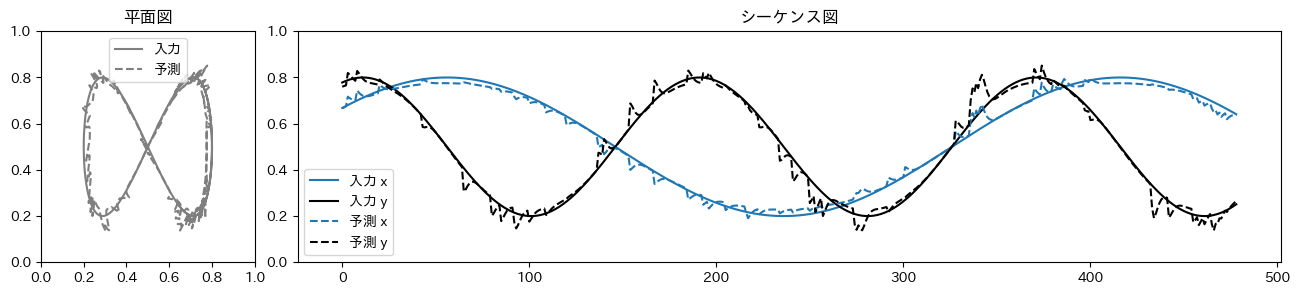

In [43]:
#@title 信号の遅延での予測

# 前向き計算による予測
delay_time = 32  # 仮想障害実験ではここを調整！
predictions_delay = rnn_altered.forward_delay(
    targets_torch,
    delay_time=delay_time,
    abnormal_prob=0.1,  # 仮想障害実験ではここを調整！
).detach().numpy()

# 予測結果をプロット
for idx in range(2):
    plot_sequences(
        targets=targets[idx, delay_time+1:, :],
        predictions=predictions_delay[idx, delay_time:-1, :]
    )

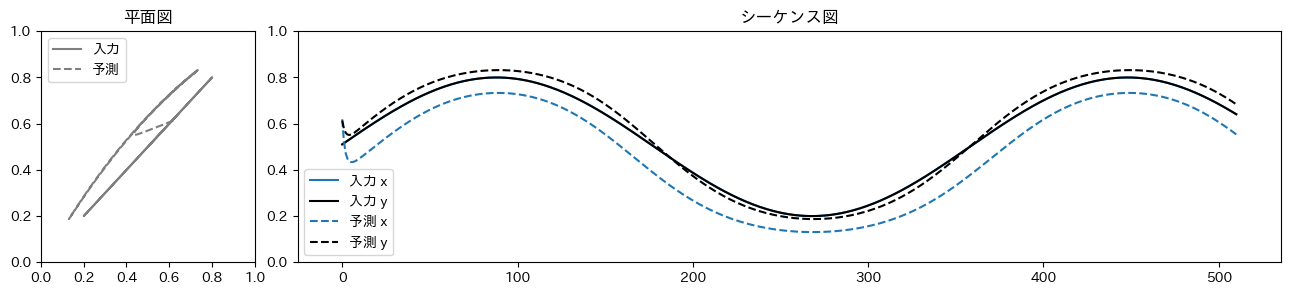

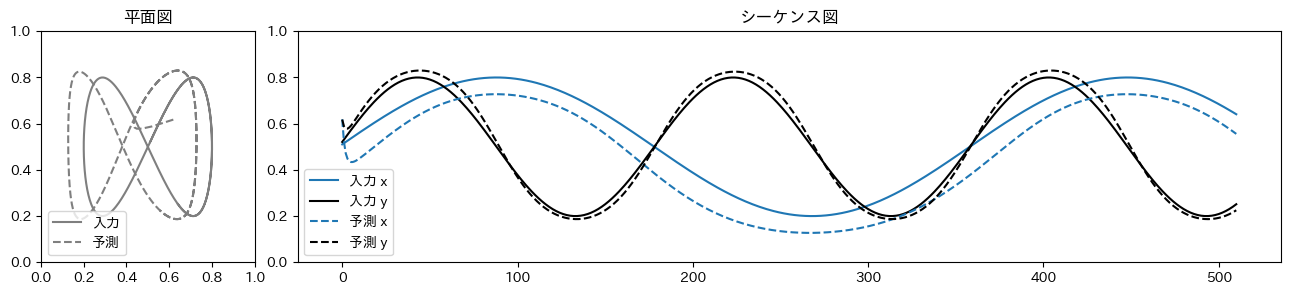

In [44]:
#@title シナプス結合の切断での予測

# 前向き計算による予測
predictions_disconnection = rnn_altered.forward_disconnection(
    targets_torch,
    disconnection_prob=0.2,  # 仮想障害実験ではここを調整！
).detach().numpy()

# 予測結果をプロット
for idx in range(2):
    plot_sequences(
        targets=targets[idx, 1:, :],
        predictions=predictions_disconnection[idx, :-1, :]
    )

# コラム

## 勾配降下法のフィギュア作成

-1.4 0.1456000000000004 3.144


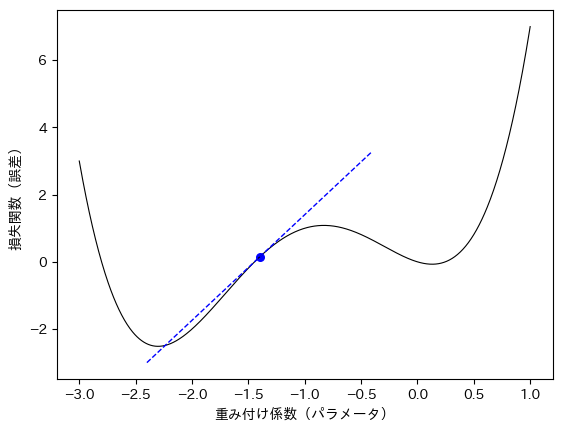

In [45]:
def funtest(x):
    return x*x*x*x + 4*x*x*x + 3*x*x - x
def derivative(x):
    return 4*x*x*x + 12*x*x + 6*x - 1
def tangent(point, lin):
    return derivative(point)*lin - derivative(point)*point + funtest(point)

lin_whole = np.linspace(-3, 1, 1000)
point = -1.4
lin_tangent = np.linspace(point - 1.0, point + 1.0, 1000)
print(point, funtest(point), derivative(point))

plt.plot(lin_whole, funtest(lin_whole), color='black', linewidth=0.8)
plt.scatter(point, funtest(point), s=30, color='blue')
plt.plot(lin_tangent, tangent(point=point, lin=lin_tangent), color='blue', linewidth=1.0, linestyle='dashed')
plt.xlabel('重み付け係数（パラメータ）')
plt.ylabel('損失関数（誤差）')
plt.show()